In [31]:
import os
import torch
import torch.nn as nn 
import torch.optim as optim
from pathlib import Path
import pandas as pd 
from sklearn.model_selection import train_test_split
import shutil
import torchvision.transforms as transforms 
from torchvision import datasets,models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import warnings
import copy
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import wandb

In [12]:
warnings.filterwarnings("ignore")

## Configuration of the folders 

In [5]:
Home= Path().resolve().as_posix()

In [ ]:

os.mkdir(Home+"/Training")
os.mkdir(Home+"/Validation")
os.mkdir(Home+"/Testing")

In [132]:
Priority_Length=len(os.listdir(Home+"/total/Priority"))
Stop_Length=len(os.listdir(Home+"/total/Stop"))
total_length=Priority_Length+Stop_Length

In [133]:
df_Priority=pd.DataFrame(columns=["image_path","label"],index=[i for i in range(Priority_Length)])
df_Priority["image_path"]=os.listdir(Home+"/total/Priority")
df_Priority["label"]="Priority"

df_Stop=pd.DataFrame(columns=["image_path","label"],index=[i for i in range(Stop_Length)])
df_Stop["image_path"]=os.listdir(Home+"/total/Stop")
df_Stop["label"]="Stop"

## Data Spiltting

In [134]:
x_priority=df_Priority.image_path
y_priority=df_Priority.label
X_train_priority,X_test_priority,y_train_priority,y_test_priority=train_test_split(x_priority,y_priority,test_size=0.30,random_state=42)
X_train_priority,X_valid_priority,y_train_priority,y_valid_priority=train_test_split(X_train_priority,y_train_priority,test_size=0.20,random_state=42)

In [136]:
x_Stop=df_Stop.image_path
y_Stop=df_Stop.label
X_train_Stop,X_test_Stop,y_train_Stop,y_test_Stop=train_test_split(x_Stop,y_Stop,test_size=0.30,random_state=42)
## change to 30 percent
X_train_Stop,X_valid_Stop,y_train_Stop,y_valid_Stop=train_test_split(X_train_Stop,y_train_Stop,test_size=0.20,random_state=42)

In [143]:
X_train=list(X_train_priority)+list(X_train_Stop)
y_train=list(y_train_priority)+list(y_train_Stop)
###############################
X_valid=list(X_valid_priority)+list(X_valid_Stop)
y_valid=list(y_valid_priority)+list(y_valid_Stop)
###############################
X_test=list(X_test_priority)+list(X_test_Stop)
y_test=list(y_test_priority)+list(y_test_Stop)

In [145]:
df_training=pd.DataFrame(columns=["image_path","label"],index=[i for i in range(len(X_train))])
df_training["image_path"]=X_train
df_training["label"]=y_train

df_Validation=pd.DataFrame(columns=["image_path","label"],index=[i for i in range(len(X_valid))])
df_Validation["image_path"]=X_valid
df_Validation["label"]=y_valid


df_Test=pd.DataFrame(columns=["image_path","label"],index=[i for i in range(len(X_test))])
df_Test["image_path"]=X_test
df_Test["label"]=y_test

In [146]:
train_priority=df_training[df_training["label"]=="Priority"]["image_path"].values.tolist()
train_Stop=df_training[df_training["label"]=="Stop"]["image_path"].values.tolist()

valid_priority=df_Validation[df_Validation["label"]=="Priority"]["image_path"].values.tolist()
valid_Stop=df_Validation[df_Validation["label"]=="Stop"]["image_path"].values.tolist()

test_priority=df_Test[df_Test["label"]=="Priority"]["image_path"].values.tolist()
test_Stop=df_Test[df_Test["label"]=="Stop"]["image_path"].values.tolist()

In [148]:
os.mkdir(Home+"/Training/Priority")
os.mkdir(Home+"/Training/Stop")

os.mkdir(Home+"/Validation/Priority")
os.mkdir(Home+"/Validation/Stop")

os.mkdir(Home+"/Testing/Priority")
os.mkdir(Home+"/Testing/Stop")

In [149]:
def copy_data(source,destination,path_list):
    for image in path_list:
        image_src_path=source+'/'+image
        image_dest_path=destination+'/'+image
        shutil.copy(image_src_path,image_dest_path)

In [150]:
# copy the priorrity training data to training priority
source=Home+"/total/Priority"
destination=Home+"/Training/Priority"
copy_data(source,destination,train_priority)

# copy the priority validation data to validation priority
destination1=Home+"/Validation/Priority"
copy_data(source,destination1,valid_priority)

# copy the priority testing data to testing priority
destination2=Home+"/Testing/Priority"
copy_data(source,destination2,test_priority)

##################################################################################### 
# copy the stop training data to training Stop
source1=Home+"/total/Stop"
destination3=Home+"/Training/Stop"
copy_data(source1,destination3,train_Stop)

# copy the Stop validation data to validation Stop 
destination4=Home+"/Validation/Stop"
copy_data(source1,destination4,valid_Stop)

# copy the stop test data to  test stop
destination5=Home+"/Testing/Stop"
copy_data(source1,destination5,test_Stop)


In [3]:
def load_data(tra_path, val_path): 
    transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 
    trainset = datasets.ImageFolder(root=tra_path, transform=transform) 
    validset = datasets.ImageFolder(root=val_path, transform=transform) #
    return trainset, validset

In [6]:
train_path=Home+"/Training"
valid_path=Home+"/Validation"
train_set,valid_set=load_data(train_path,valid_path)

In [7]:
# Define batch size for data loader 
batch_size = 32 
# Create data loaders for training and validation sets 
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True) 
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

In [8]:
def denormalize(tensor, mean, std): 
    tensor = tensor.clone() # Clone tensor to avoid modifying the original tensor 
    for t, m, s in zip(tensor, mean, std): 
        t.mul_(s).add_(m) # Unnormalize the image 
    return tensor

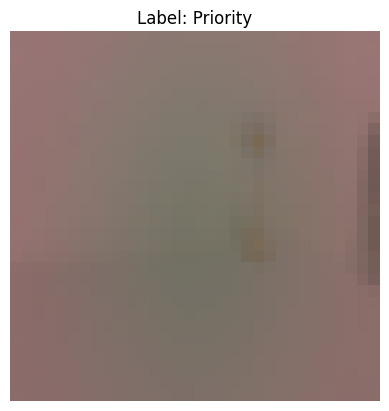

In [9]:
# Get one batch of images and labels 
images, labels = next(iter(train_loader)) 
# Select one image from the batch 
image = images[0] 
label = labels[0] 
# Denormalize the image 
image = denormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
# Convert the image tensor to a NumPy array 
image = image.numpy().transpose((1, 2, 0)) 
# Plot the image 
plt.imshow(image) 
plt.title(f'Label: {train_set.classes[label]}') 
plt.axis('off') 
plt.show()

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
# Load pre-trained ResNet-18 model and modify it 
model = models.resnet18(pretrained=True) 
num_ftrs = model.fc.in_features 
model.fc = nn.Linear(num_ftrs,2)
model = model.to(device) 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

c:\Users\Ismail\Desktop\Task2\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ismail\Desktop\Task2\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
for name, param in model.named_parameters(): 
    print(f"{name}: {param.shape}")

conv1.weight: torch.Size([64, 3, 7, 7])
bn1.weight: torch.Size([64])
bn1.bias: torch.Size([64])
layer1.0.conv1.weight: torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight: torch.Size([64])
layer1.0.bn1.bias: torch.Size([64])
layer1.0.conv2.weight: torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight: torch.Size([64])
layer1.0.bn2.bias: torch.Size([64])
layer1.1.conv1.weight: torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight: torch.Size([64])
layer1.1.bn1.bias: torch.Size([64])
layer1.1.conv2.weight: torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight: torch.Size([64])
layer1.1.bn2.bias: torch.Size([64])
layer2.0.conv1.weight: torch.Size([128, 64, 3, 3])
layer2.0.bn1.weight: torch.Size([128])
layer2.0.bn1.bias: torch.Size([128])
layer2.0.conv2.weight: torch.Size([128, 128, 3, 3])
layer2.0.bn2.weight: torch.Size([128])
layer2.0.bn2.bias: torch.Size([128])
layer2.0.downsample.0.weight: torch.Size([128, 64, 1, 1])
layer2.0.downsample.1.weight: torch.Size([128])
layer2.0.downsample.1.bias: torch.Size([128])
l

In [17]:
def train_my_model(num_epoch,criterion,optimizer):
    for epoch in range(num_epoch): 
        # Training phase 
        model.train() 
        train_loss = 0 
        for images, labels in train_loader: 
            optimizer.zero_grad() 
            outputs = model(images) 
            loss = criterion(outputs, labels) 
            loss.backward() 
            optimizer.step() 

        train_loss += loss.item()
        ## append in train loss 
        train_loss /= len(train_loader) 

        # Validation phase 
        model.eval() 
        val_loss = 0 
        correct = 0 
        with torch.no_grad(): 
            for images, labels in valid_loader: 
                outputs = model(images) 
                loss = criterion(outputs, labels) 
                # append valid loss 
                val_loss += loss.item() 
                _, predicted = torch.max(outputs, 1) 
                correct += (predicted == labels).sum().item() 
        
        val_loss /= len(valid_loader) 
        val_accuracy = correct / len(valid_loader.dataset)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    return model

In [18]:
model=train_my_model(20,criterion,optimizer)

Epoch 1, Train Loss: 0.0008, Val Loss: 0.2791, Val Accuracy: 0.9259
Epoch 2, Train Loss: 0.0002, Val Loss: 0.3120, Val Accuracy: 0.9259
Epoch 3, Train Loss: 0.0002, Val Loss: 0.1931, Val Accuracy: 0.9444
Epoch 4, Train Loss: 0.0000, Val Loss: 0.1496, Val Accuracy: 0.9444
Epoch 5, Train Loss: 0.0023, Val Loss: 0.2039, Val Accuracy: 0.9259
Epoch 6, Train Loss: 0.0003, Val Loss: 0.1611, Val Accuracy: 0.9259
Epoch 7, Train Loss: 0.0001, Val Loss: 0.1339, Val Accuracy: 0.9074
Epoch 8, Train Loss: 0.0002, Val Loss: 0.1423, Val Accuracy: 0.9259
Epoch 9, Train Loss: 0.0008, Val Loss: 0.1396, Val Accuracy: 0.9259
Epoch 10, Train Loss: 0.0002, Val Loss: 0.1623, Val Accuracy: 0.9074
Epoch 11, Train Loss: 0.0001, Val Loss: 0.2179, Val Accuracy: 0.9074
Epoch 12, Train Loss: 0.0712, Val Loss: 0.2040, Val Accuracy: 0.9074
Epoch 13, Train Loss: 0.0012, Val Loss: 0.1363, Val Accuracy: 0.9259
Epoch 14, Train Loss: 0.0009, Val Loss: 0.1751, Val Accuracy: 0.9074
Epoch 15, Train Loss: 0.0004, Val Loss: 0.3

## Predition on testing data

In [19]:
tst_path=Home+"/Testing"

In [20]:
transform_test = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 
testset = datasets.ImageFolder(root=tst_path, transform=transform_test) 
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [21]:
predictions = [] 
with torch.no_grad(): 
    for images,_  in testloader: 
        outputs = model(images) 
        _, predicted = torch.max(outputs, 1) 
        predictions.extend(predicted.tolist())

In [22]:
print(predictions)

[0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [23]:
image_paths = [] 
# Iterate over the files in the directory and append their paths to the list 
for root, dirs, files in os.walk(tst_path): 
    for file in files: 
        if file.endswith(".jpg"): 
            file_path = os.path.join(root, file) 
            image_paths.append(file_path)

In [24]:
len(predictions),len(image_paths)

(114, 114)

In [25]:
results = pd.DataFrame(columns=['image', 'class','id'])

In [26]:
results['image'] = image_paths
results['id'] = predictions

In [27]:
id2label = {0: 'Priority', 1: 'Stop'}
results['class'] = results['id'].apply(lambda x: id2label[x])
results

,image,class,id
0,C:/Users/Ismail/Desktop/Task2/Testing\Priority...,Priority,0
1,C:/Users/Ismail/Desktop/Task2/Testing\Priority...,Stop,1
2,C:/Users/Ismail/Desktop/Task2/Testing\Priority...,Priority,0
3,C:/Users/Ismail/Desktop/Task2/Testing\Priority...,Priority,0
4,C:/Users/Ismail/Desktop/Task2/Testing\Priority...,Priority,0
...,...,...,...
109,C:/Users/Ismail/Desktop/Task2/Testing\Stop\f2e...,Stop,1
110,C:/Users/Ismail/Desktop/Task2/Testing\Stop\f3f...,Stop,1
111,C:/Users/Ismail/Desktop/Task2/Testing\Stop\f42...,Stop,1
112,C:/Users/Ismail/Desktop/Task2/Testing\Stop\fbb...,Stop,1


In [28]:
data_list_Priority=["Priority"]*46
data_list_Stop=["Stop"]*68
Total_data=data_list_Priority+data_list_Stop
results["Goldsatndard"]=Total_data



In [29]:
accuracy_score(results["Goldsatndard"].values.tolist(), results["class"].values.tolist())

0.9736842105263158

## Save model

In [30]:
torch.save(model.state_dict(), 'Ismail_MSE_imageclassfication_modelV0.1.pth')

In [2]:
os.environ["WANDB_NOTEBOOK_NAME"] = "Imageclassfication.ipynb"

In [4]:
run=wandb.init(project="Image_Classificationv0")
artifact=wandb.Artifact('model',type='model')
artifact.add_file('Task2\Ismail_MSE_imageclassfication_model.pth')
run.log_artifact(artifact)
run.finish()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

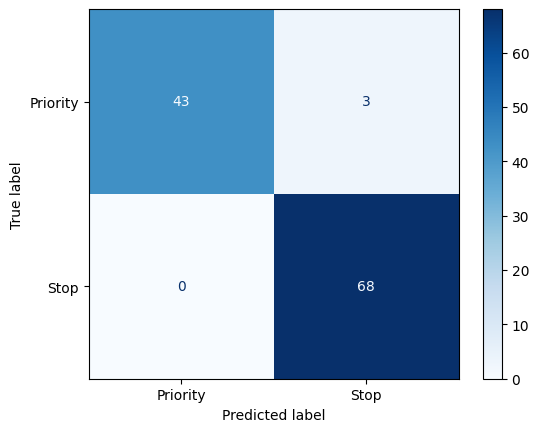

In [32]:
# Compute confusion matrix
cm = confusion_matrix(results["Goldsatndard"].values.tolist(), results["class"].values.tolist())

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=results["Goldsatndard"].unique().tolist())
disp.plot(cmap=plt.cm.Blues)
plt.show()